<a href="https://colab.research.google.com/github/JapeTheEternalChild/LSTM-Streamflowprediction-with-Keras/blob/main/Callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
# import libraries
from pydrive.drive import GoogleDrive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import glob
# load keras and co
import keras
from numpy import loadtxt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import CuDNNLSTM
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import torch
# from sklearn
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
# Import & Preprocess Data Function

def read_data(filename_daymet, filename_flow):
  # daily metereo mean data
  daymet = pd.read_csv(filename_daymet, sep='\t', header=4)
  daymet.columns =['Datetime', 'dayl(s)', 'prcp(mm/d)', 'srad(W/m2)', 'swe(mm)', 'tmax(c)', 'tmin(C)', 'vp(Pa)']  # name columns
  # get catchment area
  with open(filename_daymet, 'r') as fp:
      content = fp.readlines()
      area = int(content[2])
  # daily streamflow data
  flow = pd.read_csv(filename_flow, header=None, delim_whitespace=True)
  flow = flow[4] # select column
  flow = flow[1:] # drop first line 1.1.1980 because daymet starts from the 2.1.1980
  flow.reset_index(drop=True, inplace=True) # reset index
  flow = 28316846.592 * flow * 86400 / (area * 10 ** 6) # from cubic feet per second to equivalent water column in mm
  # combine daymet and streamflow
  data = pd.concat([daymet, flow], axis=1)
  data['Datetime'] =  pd.to_datetime(data['Datetime'], format='%Y %m %d %H')  # set Datetime format
  data['Datetime'] = pd.to_datetime(data['Datetime']).dt.date # drop hours
  data = data.set_index(pd.DatetimeIndex(data['Datetime']))
  data = data.drop(['swe(mm)'], axis=1)
  data = data.drop(['Datetime'], axis=1)
  data = data.drop(['dayl(s)'], axis=1)
  data_old = data.shape[0]
  # delete missing data
  
  data.columns =['prcp(mm/d)', 'srad(W/m2)', 'tmax(c)', 'tmin(C)', 'vp(Pa)', 'Q_spec(mm)']  # name columns
  idxNegatives = data[data['Q_spec(mm)'] < 0].index 
  data.drop(idxNegatives, inplace = True)
  data.dropna(inplace = True)
  # Print how many samples where deleted
  deleted = data_old-data.shape[0]
  print( deleted, 'SAMPLES WHERE DELETED DUE TO MISSING DATA')

  return data

# split data

def split_data1(data):
  df_train = data['1980-10-01':'1995-09-30']
  df_test = data['1995-10-01':'2010-09-30']
  return df_train, df_test

# Z-Standartization --> scaling of data (mean=0, standard deviation = 1)

def local_standartization(data):
  stds = data.std()
  mean = data.mean()
  scaled_data = (data-mean)/stds
  return scaled_data, stds, mean

def scale(data, stds, mean):
  scaled_data = (data-mean)/stds
  return scaled_data

# Rescaling discharge values 

def rescale(data_discharge, stds, mean):
  y_stds = stds.loc['Q_spec(mm)']
  y_mean = mean.loc['Q_spec(mm)']
  rescaled_discharge = (data_discharge * y_stds) +  y_mean
  return rescaled_discharge

# shift timeseries for t days

def shift(data, t):
  data_to_shift = data.drop(['Q_spec(mm)'], axis = 1)
  Q = data['Q_spec(mm)']
  lags= range(0,t)
  data_shifted = pd.concat([data_to_shift.shift(t).add_suffix(f" (t-{t})") for t in lags], axis=1)
  data_shifted = pd.concat([data_shifted, Q], axis = 1)
  return data_shifted

# split dataframe into train and test data; define input(x) and control(y) values; reshape input df from 2D to 3D

def split_data(train_shifted, test_shifted):
  #df_train = train_shifted['1980-10-01':'1995-09-30']
  #df_test = test_shifted['1995-10-01':'2010-09-30']
  y_train = train_shifted['Q_spec(mm)'].values
  x_train = train_shifted.loc[:, train_shifted.columns != 'Q_spec(mm)'].values
  y_test = test_shifted['Q_spec(mm)'].values
  x_test = test_shifted.loc[:, test_shifted.columns != 'Q_spec(mm)'].values
  #x_train = np.expand_dims(x_train,2)
  #x_test = np.expand_dims(x_test, 2)
  return y_train, x_train, y_test, x_test

#NSE function
def get_nse(y_test, predictions):
  numerator = sum([(y_test[i]-predictions[i])**2 for i in range(len(y_test))])
  y_test_avg = sum(y_test)/len(y_test)
  denominator = sum([(y_test[i]-y_test_avg)**2 for i in range(len(y_test))])
  NSE = 1- (numerator/denominator)
  return NSE

def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

#using NSE as metrics function
def metrics_nse(y_obs,y_sim):
  numerator = K.sum(K.square(y_sim - y_obs))
  denominator = K.sum(K.square(y_obs - K.mean(y_obs)))
  return 1-(numerator/denominator)

#using NSE as loss function
def loss_NSE(y_obs, y_sim):
  numerator = K.sum(K.square(y_sim - y_obs))
  denominator = K.sum(K.square(y_obs - K.mean(y_obs)))
  return numerator/denominator

#LSTM

def model_lstm(x_train, loss, metrics):
  model = Sequential()
  model.add(LSTM(20, input_shape=x_train.shape[1:], return_sequences = True, activation = "tanh"))
  model.add(Dropout(0.1))
  model.add(LSTM(20, activation = "tanh"))
  model.add(Dropout(0.1))
  model.add(Dense(1))
  model.compile(loss=loss, optimizer='adam', metrics=metrics)

  print(model.summary())

  return model

# optimizer



# GRU
''' gated recurrent unit after Cho, et al. in 2014
using a keras based sequencial model '''

def model_gru(x_train, loss, metrics):
  model = Sequential()
  model.add(GRU(20, activation="tanh", input_shape=x_train.shape[1:], use_bias=True, return_sequences = True, recurrent_activation="sigmoid"))
  model.add(Dropout(0.1))
  model.add(GRU(20, activation="tanh", use_bias=True, recurrent_activation="sigmoid"))
  model.add(Dropout(0.1))
  model.add(Dense(1))
  model.compile(loss=loss, optimizer=opt, metrics=metrics)

  print(model.summary())

  return model

# Train the Model

def train(model, x_train, y_train, epochs, batch_size):
 history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)
 return history

 # Evaluate model

def get_accuracy(model,x,y):
 loss = model.evaluate(x, y)
 return loss

# Validation

def prediction(model, x_test):
  predictions = model.predict(x_test)
  return predictions

def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
# Prepare the list for the transformed data
    X, y = list(), list()
# Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
# if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
# Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
# Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
# Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array


# Callbacks

class PredictionCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        
    def on_epoch_end(self, epoch, logs=None):
        print('predicting model...')
        prediction_current = self.model.predict(self.x_test)
        np.save('/content/drive/My Drive/Colab Notebooks/Evaluation/TrainingProgress/prediction_'+str(epoch)+'.npy', prediction_current)



In [ ]:
huc = '01'
basin_ID = '01013500'
filename_daymet ='/content/drive/My Drive/Colab Notebooks/basin_mean_forcing/daymet/'+huc+'/'+basin_ID+'_lump_cida_forcing_leap.txt'
filename_flow   ='/content/drive/My Drive/Colab Notebooks/usgs_streamflow/'+huc+'/'+basin_ID+'_streamflow_qc.txt'
data = read_data(filename_daymet, filename_flow)

df_train, df_test = split_data1(data)
scaled_train, train_std, train_mean = local_standartization(df_train)
scaled_test = scale(df_test, train_std, train_mean)
y_train_sc, x_train_sc, y_test_sc, x_test_sc = split_data(scaled_train, scaled_test)

num_steps = 365
# training set
(x_train_transformed,
y_train_transformed) = lstm_data_transform(x_train_sc, y_train_sc, num_steps=num_steps)
assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(x_test_transformed,
y_test_transformed) = lstm_data_transform(x_test_sc, y_test_sc, num_steps=num_steps)
assert x_test_transformed.shape[0] == y_test_transformed.shape[0]

loss = 'mse'
epochs=50
batch_size = 512

checkpoint_filepath = '/content/drive/My Drive/Colab Notebooks/Evaluation/TrainingProgress'

checkpoint = keras.callbacks.ModelCheckpoint( filepath = checkpoint_filepath, save_best_only=False, save_freq= 'epoch')

performance_simple = PredictionCallback(x_test_transformed, y_test_transformed)

model = model_lstm(x_train_transformed, loss, metrics=metrics_nse)
opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
history = model.fit(x_train_transformed, y_train_transformed, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[performance_simple])

92 SAMPLES WHERE DELETED DUE TO MISSING DATA
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 365, 20)           2080      
                                                                 
 dropout_4 (Dropout)         (None, 365, 20)           0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,381
Trainable params: 5,381
Non-trainable params: 0
_________________________________________________________________
None
Ep

In [ ]:
df_test.index[1364:1729]

DatetimeIndex(['1999-06-26', '1999-06-27', '1999-06-28', '1999-06-29',
               '1999-06-30', '1999-07-01', '1999-07-02', '1999-07-03',
               '1999-07-04', '1999-07-05',
               ...
               '2000-06-15', '2000-06-16', '2000-06-17', '2000-06-18',
               '2000-06-19', '2000-06-20', '2000-06-21', '2000-06-22',
               '2000-06-23', '2000-06-24'],
              dtype='datetime64[ns]', name='Datetime', length=365, freq=None)

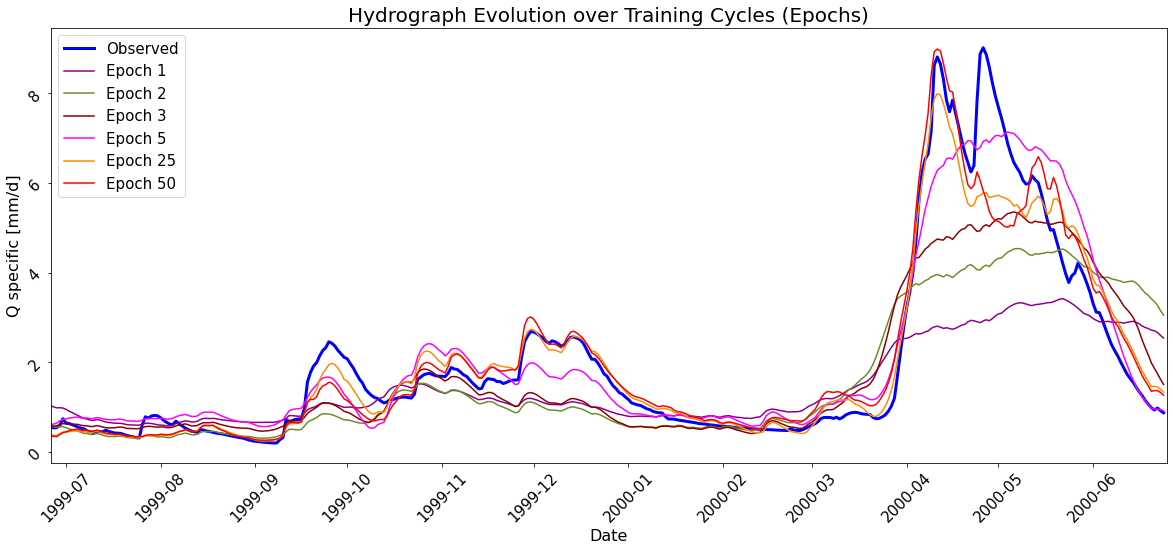

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Evaluation/TrainingProgress')



epoch1 = np.load('prediction_1.npy')
epoch1 = rescale(epoch1, train_std, train_mean)
epoch2 = np.load('prediction_2.npy')
epoch2 = rescale(epoch2, train_std, train_mean)
epoch3 = np.load('prediction_3.npy')
epoch3 = rescale(epoch3, train_std, train_mean)
epoch5 = np.load('prediction_5.npy')
epoch5 = rescale(epoch5, train_std, train_mean)
epoch10 = np.load('prediction_10.npy')
epoch10 = rescale(epoch10, train_std, train_mean)
epoch25 = np.load('prediction_25.npy')
epoch25 = rescale(epoch25, train_std, train_mean)
epoch40 = np.load('prediction_40.npy')
epoch40 = rescale(epoch40, train_std, train_mean)
epoch50 = prediction(model, x_test_transformed)
epoch50 = rescale(epoch50, train_std, train_mean)

observed = rescale(y_test_sc, train_std, train_mean)



from matplotlib.pyplot import figure

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 8)
ax.plot(df_test.index[1364:1729], observed[1364:1729], 'b', linewidth = 3)
ax.plot(df_test.index[1364:1729], epoch1[1000:1365], '-' , color='darkmagenta')
ax.plot(df_test.index[1364:1729], epoch2[1000:1365], '-', color='olivedrab')
ax.plot(df_test.index[1364:1729], epoch3[1000:1365], '-', color ='darkred')
ax.plot(df_test.index[1364:1729], epoch5[1000:1365], '-', color = 'magenta')
#plt.plot(epoch10[1000:1365], '-')
ax.plot(df_test.index[1364:1729], epoch25[1000:1365], '-', color = 'darkorange')
#plt.plot(epoch40[1000:1365], '-')
ax.plot(df_test.index[1364:1729], epoch50[1000:1365], '-', color='r')
ax.legend(['Observed', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 5', 'Epoch 25', 'Epoch 50'],  fontsize = 15)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Q specific [mm/d]', fontsize = 16)
ax.set_title('Hydrograph Evolution over Training Cycles (Epochs)', fontsize = 20)
ax.set_xlim(df_test.index[1364], df_test.index[1729], )
ax.tick_params(labelsize=15, rotation = 45)

os.chdir('/content/drive/My Drive/Colab Notebooks/Evaluation/figure')

plt.savefig('Epoch_Evolution.png', bbox_inches='tight')